# Lesson 1 Demo — From Regression to Deep Learning

This notebook mirrors the Lesson 1 slides: generate a non-linear 2D dataset,
train a small PyTorch model, and visualize decision regions.

## Setup
If packages are missing, uncomment the pip installs.

In [2]:
import sys
print("Python:", sys.executable)

import numpy as np
print("NumPy:", np.__version__)

import torch
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

x = torch.tensor([1.0,2.0,3.0])
print("Test tensor:", (x*2).tolist())


Python: d:\Agasy_lessons\.venv\Scripts\python.exe
NumPy: 2.2.6
PyTorch: 2.9.1+cpu
CUDA available: False
Test tensor: [2.0, 4.0, 6.0]


In [3]:
# !pip install -q torch matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Make a 2D dataset
We use `make_circles` if available; otherwise a lightweight spiral generator.

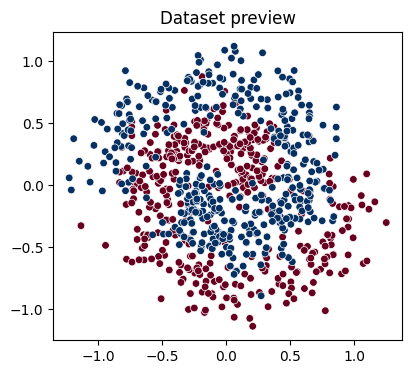

In [4]:
def make_spiral(n=500, noise=0.2, seed=0):
    rng = np.random.default_rng(seed)
    n2 = n // 2
    t = np.linspace(0, 2*np.pi, n2)
    r = np.linspace(0.2, 1.0, n2)
    x1 = np.c_[r*np.cos(t), r*np.sin(t)] + noise * rng.standard_normal((n2, 2))
    x2 = np.c_[-r*np.cos(t), -r*np.sin(t)] + noise * rng.standard_normal((n2, 2))
    Xs = np.vstack([x1, x2]).astype('float32')
    ys = np.r_[np.zeros(n2), np.ones(n2)].astype('float32')
    return Xs, ys

X, y = make_spiral(n=800, noise=0.15, seed=0)

plt.figure(figsize=(4.5,4))
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', s=30, edgecolor='white', linewidth=0.5)
plt.title('Dataset preview')
plt.show()


## Build and train a small network
Two hidden layers with ReLU and a sigmoid output for binary classification.

In [5]:
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(0.8 * len(X))
train_idx, val_idx = idx[:split], idx[split:]
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]


In [6]:
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train).unsqueeze(1)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val).unsqueeze(1)

In [7]:
model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid(),
)

In [8]:
model

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Sigmoid()
)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

train_losses = []
val_losses = []

for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_t)
    loss = loss_fn(preds, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = loss_fn(val_preds, y_val_t)
        val_losses.append(val_loss.item())

model.eval()
with torch.no_grad():
    val_probs = model(X_val_t)
    val_pred_labels = (val_probs > 0.5).float()
    val_acc = (val_pred_labels.eq(y_val_t)).float().mean().item()
float(val_acc)


0.856249988079071

## Training and validation loss
Track how the model improves over epochs.


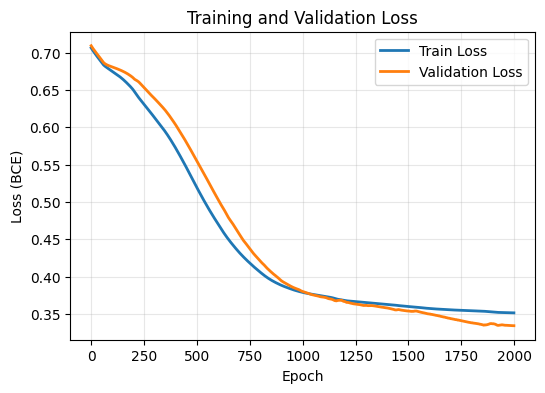

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Plot decision regions
Compare model predictions across a mesh grid with the data points.

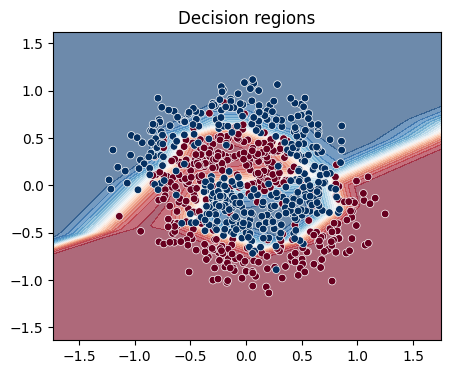

In [11]:
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
    np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()].astype('float32')
model.eval()
with torch.no_grad():
    grid_t = torch.from_numpy(grid)
    probs = model(grid_t).detach().numpy().reshape(xx.shape)

plt.figure(figsize=(5,4))
cs = plt.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', edgecolor='white', linewidth=0.5, s=30)
plt.title('Decision regions')
plt.show()


## Experiment 1: Shallow & Narrow (2 -> 4 -> 1)

#### Recreate tensors if not present (safe to run even if they exist)

In [12]:
try:
    X_train_t
    y_train_t
    X_val_t
    y_val_t
except NameError:
    X_train_t = torch.from_numpy(X_train)
    y_train_t = torch.from_numpy(y_train).unsqueeze(1)
    X_val_t = torch.from_numpy(X_val)
    y_val_t = torch.from_numpy(y_val).unsqueeze(1)

#### Reproducibility (the same)

In [13]:
torch.manual_seed(0)
np.random.seed(0)

#### Define model: 2 -> 4 -> 1 with Sigmoid

In [16]:
import torch.optim as optim
model_exp1 = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

optimizer = optim.Adam(model_exp1.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

epochs = 1000
train_losses = []
val_losses = []

for epoch in range(epochs):
    model_exp1.train()
    optimizer.zero_grad()
    preds = model_exp1(X_train_t)
    loss = loss_fn(preds, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model_exp1.eval()
    with torch.no_grad():
        val_preds = model_exp1(X_val_t)
        val_loss = loss_fn(val_preds, y_val_t)
        val_losses.append(val_loss.item())

#### Final validation accuracy

In [17]:
model_exp1.eval()
with torch.no_grad():
    val_probs = model_exp1(X_val_t)
    val_pred_labels = (val_probs > 0.5).float()
    val_acc = (val_pred_labels.eq(y_val_t)).float().mean().item()

print(f"Experiment 1 — final val accuracy: {val_acc:.4f}")

Experiment 1 — final val accuracy: 0.5750


#### Plot training & validation loss

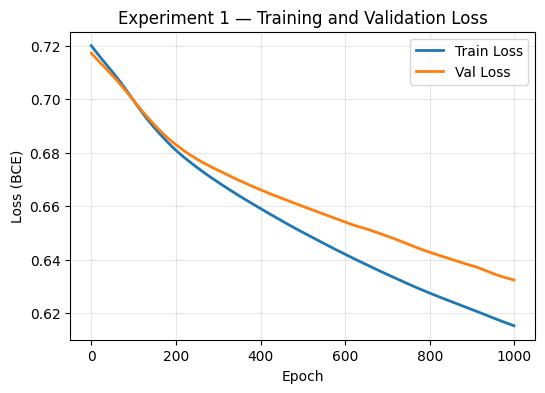

In [18]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.title('Experiment 1 — Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


####  Decision regions (same grid resolution as notebook)

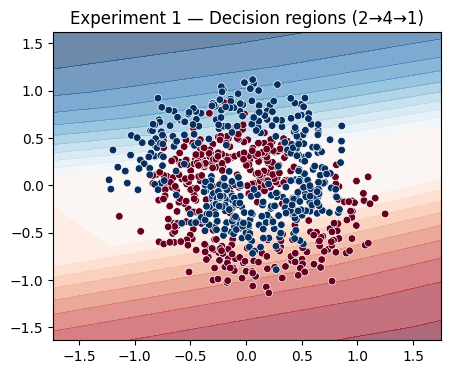

In [19]:
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
    np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()].astype('float32')
with torch.no_grad():
    grid_t = torch.from_numpy(grid)
    probs = model_exp1(grid_t).detach().numpy().reshape(xx.shape)

plt.figure(figsize=(5,4))
plt.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', edgecolor='white', linewidth=0.5, s=30)
plt.title('Experiment 1 — Decision regions (2→4→1)')
plt.show()

## Experiment 2: Wide & Deeper (2 -> 16 -> 16 -> 1)

In [20]:
model_exp2 = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

optimizer = optim.Adam(model_exp2.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

epochs = 1000
train_losses = []
val_losses = []

for epoch in range(epochs):
    model_exp2.train()
    optimizer.zero_grad()
    preds = model_exp2(X_train_t)
    loss = loss_fn(preds, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model_exp2.eval()
    with torch.no_grad():
        val_preds = model_exp2(X_val_t)
        val_loss = loss_fn(val_preds, y_val_t)
        val_losses.append(val_loss.item())

#### Final validation accuracy

In [21]:
model_exp2.eval()
with torch.no_grad():
    val_probs = model_exp2(X_val_t)
    val_pred_labels = (val_probs > 0.5).float()
    val_acc = (val_pred_labels.eq(y_val_t)).float().mean().item()

print(f"Experiment 2 — final val accuracy: {val_acc:.4f}")


Experiment 2 — final val accuracy: 0.8500


#### Plot training & validation loss

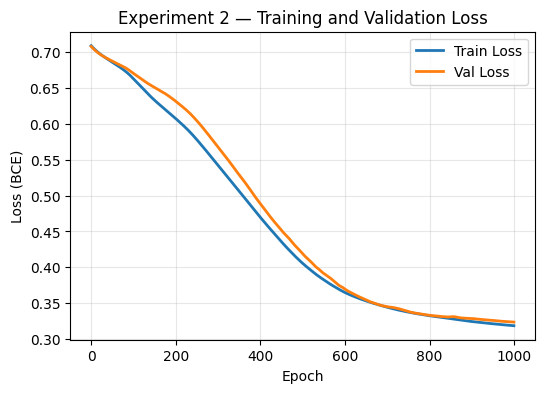

In [22]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.title('Experiment 2 — Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Decision regions (same grid resolution as notebook)

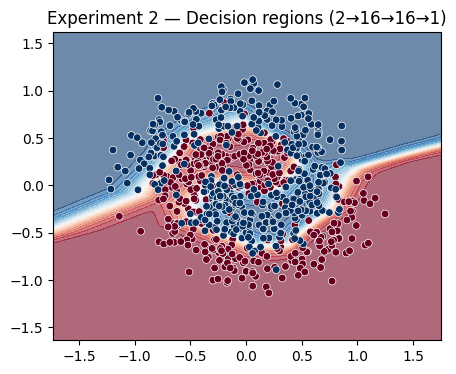

In [23]:
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
    np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()].astype('float32')
with torch.no_grad():
    grid_t = torch.from_numpy(grid)
    probs = model_exp2(grid_t).detach().numpy().reshape(xx.shape)

plt.figure(figsize=(5,4))
plt.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', edgecolor='white', linewidth=0.5, s=30)
plt.title('Experiment 2 — Decision regions (2→16→16→1)')
plt.show()

## Experiment 3: Deep & Narrow (2 -> 3 -> 3 -> 3 -> 3 -> 1)

#### Define model: deep but narrow

In [24]:
model_exp3 = nn.Sequential(
    nn.Linear(2, 3),
    nn.ReLU(),
    nn.Linear(3, 3),
    nn.ReLU(),
    nn.Linear(3, 3),
    nn.ReLU(),
    nn.Linear(3, 3),
    nn.ReLU(),
    nn.Linear(3, 1),
    nn.Sigmoid()
)

optimizer = optim.Adam(model_exp3.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

epochs = 1000
train_losses = []
val_losses = []

for epoch in range(epochs):
    model_exp3.train()
    optimizer.zero_grad()
    preds = model_exp3(X_train_t)
    loss = loss_fn(preds, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model_exp3.eval()
    with torch.no_grad():
        val_preds = model_exp3(X_val_t)
        val_loss = loss_fn(val_preds, y_val_t)
        val_losses.append(val_loss.item())

#### Final validation accuracy

In [25]:
model_exp3.eval()
with torch.no_grad():
    val_probs = model_exp3(X_val_t)
    val_pred_labels = (val_probs > 0.5).float()
    val_acc = (val_pred_labels.eq(y_val_t)).float().mean().item()

print(f"Experiment 3 — final val accuracy: {val_acc:.4f}")

Experiment 3 — final val accuracy: 0.4938


#### Plot training & validation loss

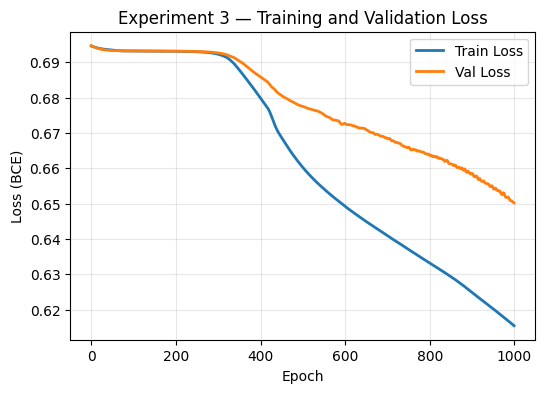

In [26]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.title('Experiment 3 — Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Decision regions

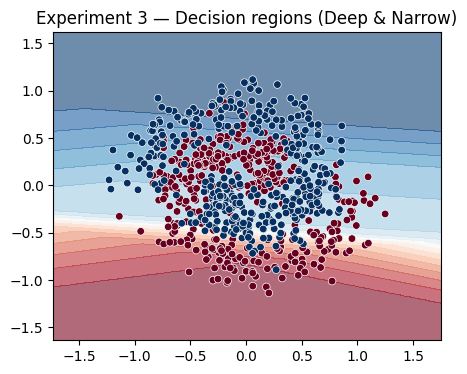

In [27]:
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
    np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()].astype('float32')
with torch.no_grad():
    grid_t = torch.from_numpy(grid)
    probs = model_exp3(grid_t).detach().numpy().reshape(xx.shape)

plt.figure(figsize=(5,4))
plt.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', edgecolor='white', linewidth=0.5, s=30)
plt.title('Experiment 3 — Decision regions (Deep & Narrow)')
plt.show()

## Experiment 4: Shallow & Narrow (2 -> 2 -> 1)

#### Define model: shallow & minimal units

In [28]:
model_exp4 = nn.Sequential(
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 1),
    nn.Sigmoid()
)

optimizer = optim.Adam(model_exp4.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

epochs = 1000
train_losses = []
val_losses = []

for epoch in range(epochs):
    model_exp4.train()
    optimizer.zero_grad()
    preds = model_exp4(X_train_t)
    loss = loss_fn(preds, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model_exp4.eval()
    with torch.no_grad():
        val_preds = model_exp4(X_val_t)
        val_loss = loss_fn(val_preds, y_val_t)
        val_losses.append(val_loss.item())

#### Final validation accuracy

In [29]:
model_exp4.eval()
with torch.no_grad():
    val_probs = model_exp4(X_val_t)
    val_pred_labels = (val_probs > 0.5).float()
    val_acc = (val_pred_labels.eq(y_val_t)).float().mean().item()

print(f"Experiment 4 — final val accuracy: {val_acc:.4f}")


Experiment 4 — final val accuracy: 0.5250


#### Plot training & validation loss

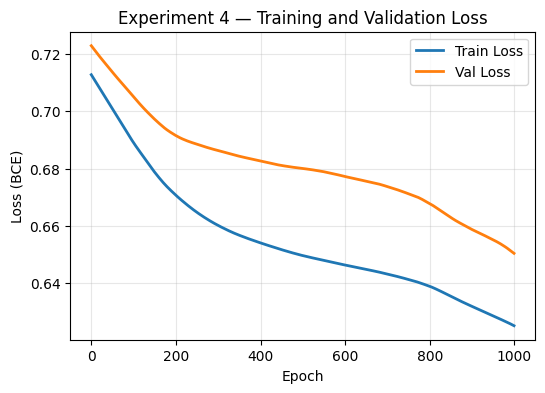

In [30]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.title('Experiment 4 — Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Decision regions

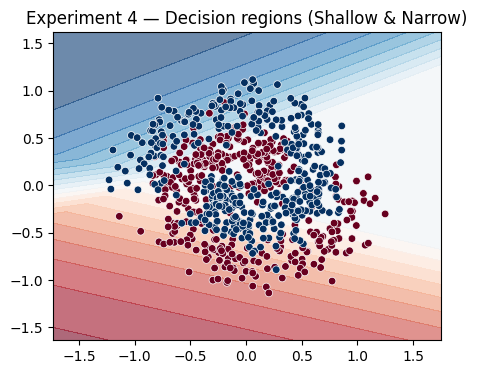

In [31]:
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
    np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()].astype('float32')
with torch.no_grad():
    grid_t = torch.from_numpy(grid)
    probs = model_exp4(grid_t).detach().numpy().reshape(xx.shape)

plt.figure(figsize=(5,4))
plt.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', edgecolor='white', linewidth=0.5, s=30)
plt.title('Experiment 4 — Decision regions (Shallow & Narrow)')
plt.show()

## Experiment 5: Wide & Deep (2 -> 32 -> 32 -> 16 -> 16 -> 8 -> 1)

#### Define model: deep & wide

In [32]:
model_exp5 = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)

optimizer = optim.Adam(model_exp5.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

epochs = 1000
train_losses = []
val_losses = []

for epoch in range(epochs):
    model_exp5.train()
    optimizer.zero_grad()
    preds = model_exp5(X_train_t)
    loss = loss_fn(preds, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model_exp5.eval()
    with torch.no_grad():
        val_preds = model_exp5(X_val_t)
        val_loss = loss_fn(val_preds, y_val_t)
        val_losses.append(val_loss.item())

#### Final validation accuracy

In [33]:
model_exp5.eval()
with torch.no_grad():
    val_probs = model_exp5(X_val_t)
    val_pred_labels = (val_probs > 0.5).float()
    val_acc = (val_pred_labels.eq(y_val_t)).float().mean().item()

print(f"Experiment 5 — final val accuracy: {val_acc:.4f}")

Experiment 5 — final val accuracy: 0.8750


#### Plot training & validation loss

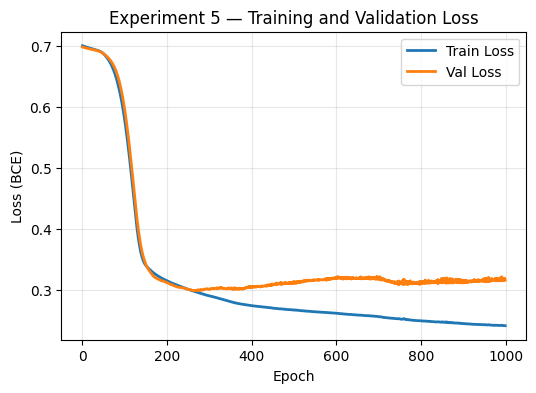

In [34]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.title('Experiment 5 — Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Decision regions

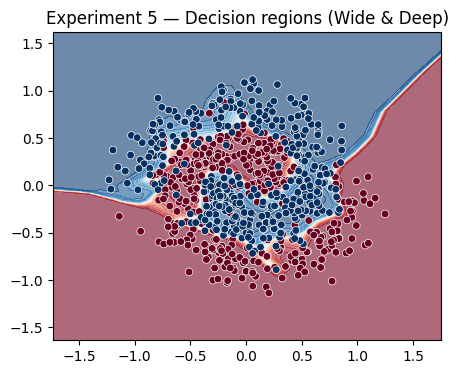

In [35]:
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
    np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()].astype('float32')
with torch.no_grad():
    grid_t = torch.from_numpy(grid)
    probs = model_exp5(grid_t).detach().numpy().reshape(xx.shape)

plt.figure(figsize=(5,4))
plt.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', edgecolor='white', linewidth=0.5, s=30)
plt.title('Experiment 5 — Decision regions (Wide & Deep)')
plt.show()

#### Experiment 1 — Shallow & Narrow (2 → 4 → 1)

**What I did:**  
- Trained a shallow network with 1 hidden layer of 4 units.  
- Used ReLU activation and Sigmoid output for binary classification.  
- Trained for 1000 epochs with Adam optimizer and BCELoss.

**Results:**  
- Final validation accuracy: **0.5750**  
- Training and validation loss gradually decreased but remained relatively high.  
- Decision boundary captured only some parts of the spirals, almost linear in many regions.

**Observations:**  
- Shallow network with few units struggles to separate complex spiral patterns.  
- Increasing the number of units or layers would likely improve boundary fitting.

##

#### Experiment 2 — Wide & Deeper (2 → 16 → 16 → 1)

**What I did:**  
- Trained a deeper and wider network with 2 hidden layers of 16 units each.  
- Used ReLU activations and Sigmoid output.  
- Trained for 1000 epochs with Adam optimizer and BCELoss.

**Results:**  
- Final validation accuracy: **0.8500**  
- Training and validation loss decreased smoothly.  
- Decision boundary captured most of the spiral patterns, much better than the shallow & narrow network.

**Observations:**  
- Increasing width and depth significantly improves the network’s ability to model complex non-linear boundaries.  
- Wide layers allow the model to fit more details in the spiral dataset without overfitting too quickly.


#### Experiment 3 — Deep & Narrow (2 → 3 → 3 → 3 → 3 → 1)

**What I did:**  
- Trained a deep network with 4 hidden layers, each containing only 3 units.  
- Used ReLU activations and Sigmoid output.  
- Trained for 1000 epochs with Adam optimizer and BCELoss.

**Results:**  
- Final validation accuracy: **0.4938**  
- Training and validation loss decreased very slowly and remained high.  
- Decision boundary failed to capture the spiral structure, mostly linear.

**Observations:**  
- Depth alone, with very few units per layer, is not sufficient to model complex patterns.  
- Minimal units limit the network’s capacity despite the increased depth.


#### Experiment 4 — Shallow & Narrow (2 → 2 → 1)

**What I did:**  
- Trained a minimal shallow network with 1 hidden layer of 2 units.  
- Used ReLU activations and Sigmoid output.  
- Trained for 1000 epochs with Adam optimizer and BCELoss.

**Results:**  
- Final validation accuracy: **0.5250**  
- Training and validation loss decreased slightly but remained relatively high.  
- Decision boundary captured very little of the spiral structure, almost linear.

**Observations:**  
- Minimal depth and minimal units severely limit network capacity.  
- Shallow & narrow networks cannot model complex non-linear patterns like spirals.


#### Experiment 5 — Wide & Deep (2 → 32 → 32 → 16 → 16 → 8 → 1)

**What I did:**  
- Trained a deep network with multiple hidden layers and a large number of units per layer.  
- Used ReLU activations and Sigmoid output.  
- Trained for 1000 epochs with Adam optimizer and BCELoss.

**Results:**  
- Final validation accuracy: **0.8750**  
- Training and validation loss decreased smoothly.  
- Decision boundary captured almost all of the spiral structure, showing excellent non-linear modeling.

**Observations:**  
- High capacity (many layers + many units) allows the network to model complex patterns effectively.  
- Risk of overfitting exists, but with 1000 epochs and this dataset, the network generalizes well.


#### Experiment 1 Architecture: (2 → 4 → 1) accuracy: 0.575
#### Experiment 2 Architecture: (2 → 16 → 16 → 1) accuracy: 0.85
#### Experiment 3 Architecture: (2 → 3 → 3 → 3 → 3 → 1) accuracy: 0.4938
#### Experiment 4 Architecture: (2 → 2 → 1) accuracy: 0.525
#### Experiment 5 Architecture: (2 → 32 → 32 → 16 → 16 → 8 → 1) accuracy: 0.8750